In [1]:
import sys, os
sys.path.append(os.pardir)

import math
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from src.detect import FaceDetector
from src.utils import try_gpu, show_bboxes

# Load models

In [2]:
detector = FaceDetector()
device = try_gpu()

# Set hyperparameters

In [3]:
# if this value is too low the algorithm will use a lot of memory
min_face_size = 15.0  

# for probabilities
thresholds = [0.6, 0.7, 0.8]

factor = 0.707  # sqrt(0.5)

# for NMS
nms_thresholds=[0.7, 0.7, 0.7]

# Load an image

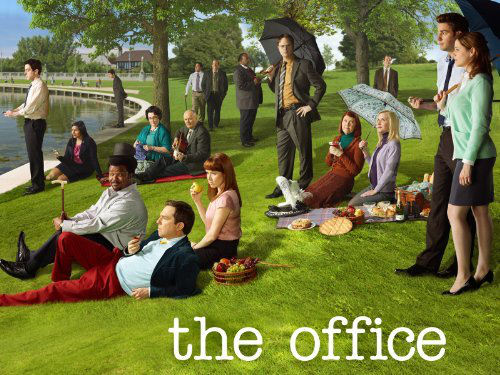

In [4]:
image = Image.open('../assets/office5.jpg')
image

# build an image pyramid

In [5]:
img = detector._preprocess(image)        
scales = detector.create_image_pyramid(img, min_face_size, factor)

print('scales:', ['{:.2f}'.format(s) for s in scales])
print('number of different scales:', len(scales))

scales: ['0.80', '0.57', '0.40', '0.28', '0.20', '0.14', '0.10', '0.07', '0.05', '0.04']
number of different scales: 10


# P-Net

In [6]:
candidate_boxes = torch.empty((0, 4), device=device)
candidate_scores = torch.empty((0), device=device)
candidate_offsets = torch.empty((0, 4), device=device)

for scale in scales:
    _, _, height, width = img.shape
    sh, sw = math.ceil(height * scale), math.ceil(width * scale)
    resize_img = F.interpolate(img, size=(sh, sw), mode='bilinear', align_corners=False)

    cls_probs, offsets = detector.pnet(resize_img)

    bboxes, scores, offsets = detector._generate_bboxes(cls_probs, offsets, scale, thresholds[0])

    candidate_boxes = torch.cat((candidate_boxes, bboxes))
    candidate_scores = torch.cat((candidate_scores, scores))
    candidate_offsets = torch.cat((candidate_offsets, offsets))

print('number of bounding boxes:', len(candidate_boxes))

number of bounding boxes: 850


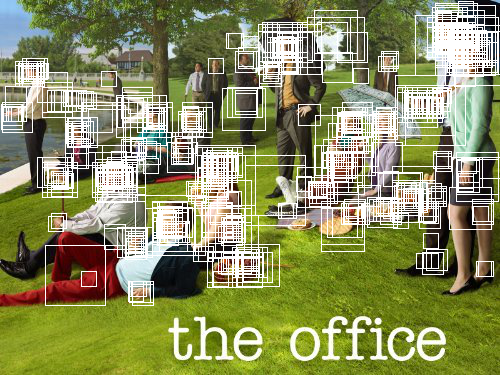

In [7]:
show_bboxes(image, candidate_boxes)

# NMS + calibration

In [8]:
keep = torchvision.ops.nms(candidate_boxes, candidate_scores, iou_threshold=nms_thresholds[0])
candidate_boxes = candidate_boxes[keep]
candidate_scores = candidate_scores[keep]
candidate_offsets = candidate_offsets[keep]

# use offsets predicted by pnet to transform bounding boxes
candidate_boxes = detector._calibrate_box(candidate_boxes, candidate_offsets)

candidate_boxes = detector._convert_to_square(candidate_boxes)
        
print('number of bounding boxes:', len(candidate_boxes))

number of bounding boxes: 467


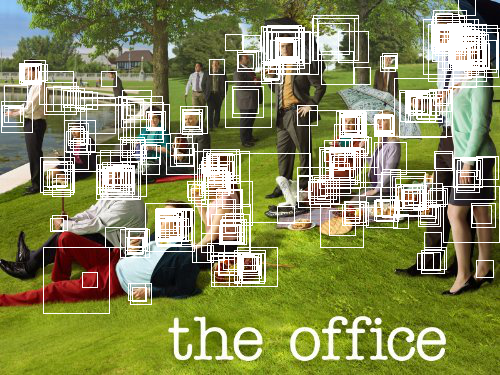

In [9]:
show_bboxes(image, candidate_boxes)

# R-Net

In [10]:
img_boxes = detector._get_image_boxes(candidate_boxes, img, size=24)

cls_probs, offsets = detector.rnet(img_boxes)

scores = cls_probs[:, 1]
keep = (scores > thresholds[1])
candidate_boxes = candidate_boxes[keep]
offsets = offsets[keep]
scores = scores[keep]

print('number of bounding boxes:', len(candidate_boxes))

number of bounding boxes: 141


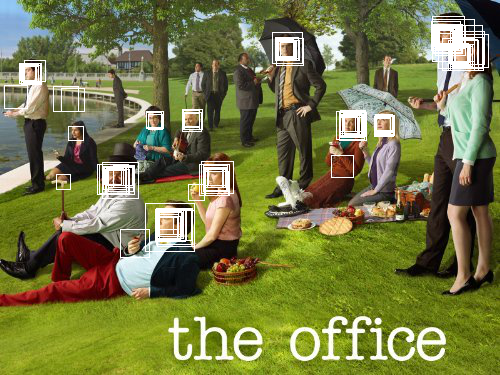

In [11]:
show_bboxes(image, candidate_boxes)

# NMS + calibration

In [12]:
keep = torchvision.ops.nms(candidate_boxes, scores, iou_threshold=nms_thresholds[1])
candidate_boxes = candidate_boxes[keep]
offsets = offsets[keep]

candidate_boxes = detector._calibrate_box(candidate_boxes, offsets)
candidate_boxes = detector._convert_to_square(candidate_boxes)
print('number of bounding boxes:', len(candidate_boxes))

number of bounding boxes: 70


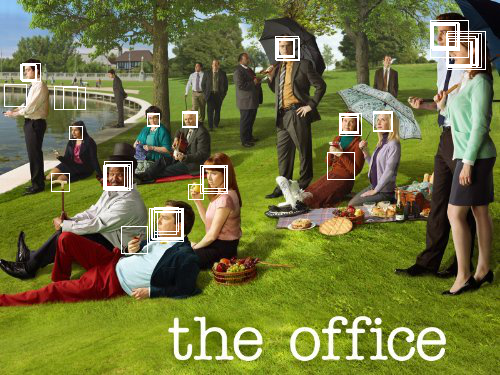

In [13]:
show_bboxes(image, candidate_boxes)

# O-Net

In [14]:
img_boxes = detector._get_image_boxes(candidate_boxes, img, size=48)

cls_probs, offsets, _ = detector.onet(img_boxes)

scores = cls_probs[:, 1]
keep = (scores > thresholds[2])
candidate_boxes = candidate_boxes[keep]
offsets = offsets[keep]
scores = scores[keep]

print('number of bounding boxes:', len(candidate_boxes))

number of bounding boxes: 61


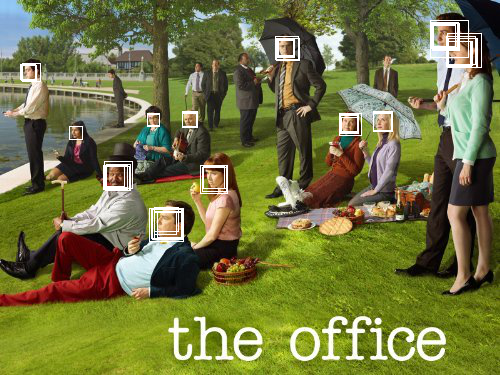

In [15]:
show_bboxes(image, candidate_boxes)

# NMS + calibration

In [16]:
candidate_boxes = detector._calibrate_box(candidate_boxes, offsets)
keep = torchvision.ops.nms(candidate_boxes, scores, iou_threshold=nms_thresholds[2])
candidate_boxes = candidate_boxes[keep]

print('number of bounding boxes:', len(candidate_boxes))

number of bounding boxes: 12


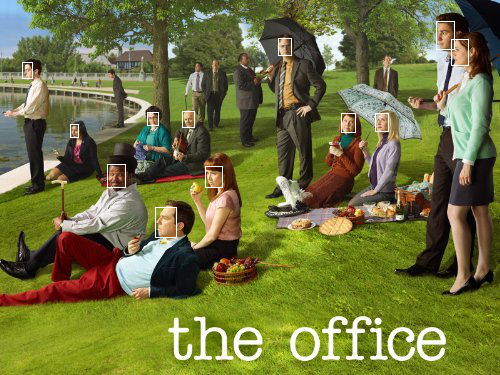

In [17]:
show_bboxes(image, candidate_boxes)